In [5]:
import numpy as np
import train as train #PA6 methods
import neuralnetworks as nn
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.figure
import pickle
import copy

# CS440 Project

Andrew Zimmeraman     
Blake Troksa  btroksa@rams.colostate.edu  

Course: CS440 Introduction to AI

Instructor: Chuck Anderson

Date: 12/12/17

## Table of Contents
* [Project Proposal](#Project-Proposal)
	* [Introduction](#Introduction)
	* [Methods](#Methods)
	* [Results](#Results)
	* [Conclusions](#Conclusions)
    * [References](#References)

## Introduction

  Andrew and Blake both worked on the process of determining the final score of Basketball games. The details of the project are described below.
  
  * ***The Problem:***  Have you ever wanted to know the outcome of basketball games before they are even played? We constructed a neural network that attempts to predict the score of an NCAA March Madness tournament games. This is useful information for multiple reasons including but not limited too:   
     
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; *1)* Making the perfect bracket: [Warren Buffet Prize](https://www.forbes.com/sites/kellyphillipserb/2014/01/21/warren-buffett-offers-1-billion-for-perfect-march-madness-bracket/#312b0fd2100b)
  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; *2)* Betting on the games to make some money
     
     This Project focuses on the prediction of the final score of a basketball game. This knowledge will specifically allow for a person to bet on the over under of a game. 
     
    
  * ***The Process:*** We implemented machine learning, specifically, neural networks to determine the final scores of these basketball games. We first gathered copious amounts of information from the Internet regarding college basketball games throughout the current season as well as previous seasons. We ended up gathering more information than we used but it was still interesting to comb through html code and different websites to find all the data that we thought we needed. We then organized this data so that we would be able to use it in our neural network training.
  
  
  * ***Why this topic:*** We choose this topic because we believe Machine Learning is an extremely popular field and doing a project in this field allowed us to get experience working with machine learning. We also think the topic of predicting basketball game scores is an interesting problem that can be solved using machine learning and specifically using neural networks. 
  
  ##### Basic Overview of the Methods Involved:
  * Gathering of information to use in the neural network   
  * Organization and formatting of information  
  * Neural Network built using the information along with Logistic Regression
  * Testing of the Neural Network and recording results

## Methods

### Data Collection

The first step of the project was collecting all the neccessary data needed to train the neural networks. For this task we used Beautiful Soup to scrape data from https://www.sports-reference.com. In order to train a neural network to predict the final overall score of an NCAA basketball game we needed data for individual game scores as well as season statistics for teams, which serve as the input data. The main purpose of the neural network is to make these predictions for future games in the NCAA Tournament so game data was scraped for every game played per year by Tournament teams from 1996 to 2017. There are 64 NCAA Tournament teams per year and each team will play 30-35 games, however, many of these games are played against other Tournament teams, so the game data consists of between 1700 to 1900 games per year. Next, team season statistics were scraped for every team that appears in our game data for that year. These stats consist of games played (G), minutes played (MP), field goals (FG), field goal attempts (FGA), field goal percentage (FG%), 2 point shots made (2P), 2 point shots attempted (2PA), 2 point shot percentage (2P%), 3 point shots made (3P), 3 point shots attempted (3PA), 3 point shot percentage (3P%), free throws made (FT), free throws attempted (FTA), free throw percentage (FT%), offensive rebounds (ORB), defensive rebounds (DRB), total rebounds (TRB), assists (AST), steals (STL), blocks (BLK), turnovers (TOV), personal fouls (PF), points (PTS), points per game (PTS/G) for the each team as well as the same set of stats for opponent teams when playing that particular team. Along with the data for the 64 Tournament teams, data was collected for the 240-290 unique teams that they played that season. It took several hours for our scraping algorithms to run and collect all the required data. After scraping all the data was complete, we reviewed the collected data to ensure there were no abnormalities. We found that team statistics before 2010 were consistently missing stats from the team's opponent data. These missing valuse were noted, and as a result input data will have to be chosen more selectively when training the neural network with data before 2010. We used pickle to store the data for later use.

In [13]:
import pickle

teamYearData = {} #dictionary with year as key and value is a list of lists containing [team1,team2,overall score] for everygame played by tournament teams
#example: '2000': [['Duke', 'Lamar', 137], ['Kansas', 'DePaul', 158]]
pickle_in = open("teamYearData.pickle","rb")
teamYearData = pickle.load(pickle_in)

tournamentGameData = {} #dictionary with year as key and value is a list of lists containing [team1,team2,overall score] for everygame in the tournament
#example: '2000': [['Duke', 'Lamar', 137], ['Kansas', 'DePaul', 158]]
pickle_in = open("tournamentGameData.pickle","rb")
tournamentGameData = pickle.load(pickle_in)

gameYearData = {} #dictionary with year as key and value is a dictionary with team as key and value in the form of [[team stats],[opponent stats]] 
#team/oppenent stats: [G, MP, FG, FGA, FG%, 2P, 2PA, 2P%, 3P, 3PA, 3P%, FT, FTA, FT%, ORB, DRB, TRB, AST, STL, BLK, TOV, PF, PTS, PTS/G]
#example: '2000': {'Duke': [[34, '', 1045, 2172, 0.481, 761, 1430, 0.532, 284, 742, 0.383, 618, 833, 0.742, 453, 860, 1313, 584, 333, 191, 480, 552, 2992, 88.0], [34, '', 934, 2238, 0.417, 737, 1686, 0.437, 197, 552, 0.357, 360, 537, 0.67, 526, 757, 1283, 472, 240, 123, 607, 690, 2425, 71.3]]}
pickle_in = open("gameYearData.pickle","rb")
gameYearData = pickle.load(pickle_in)

After we had done web scraping to find the data of team stats for every year since 1995 as well as tournament data, we decided to look through ESPN to determine if ESPN had enough information from previous years regarding the games that had been played during those years as well as the outcomes of those games. Specifically, we focused on the Regular season games that were played by all of the 351 college teams that have data recorded on ESPN.com.

After determining ESPN had useful information we decided to write some python that would access the HTML code of ESPN using HTTP GET requests and then he decided to process the HTML in order to collect the game information from it. 

The Process we used is as follows:

***1)*** Manually look at the html code that a page on the ESPN app has and determine where the useful information about game scores is stored. This included looking at the URL as well see how to access the URL for all teams in a deterministic way so that the data collection could be automated with python.   
***2)*** Begin writing a python script to retrieve the information from the individual team websites by changing the URL field that specifies the team based on the team id. This process looked like this:    

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ** 1. Access ESPN.com in order to find the list of all College Basketball teams**   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ** 2. Get the HTML of the page with all the teams using the urllib3 python module to create a GET request**   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **3. Using the python BeautifulSoup module parse the text to pull out all the data in the html text encapsulated in a table (tb tags)**   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **4. Record the team IDs of each college in the table by using regular expressions to parse the table further and get the team ID **   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **5. Using the team IDs access the individual team site based on the URL that requires the team ID and the year **   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **6. Again using the python BeautifulSoup module parse the text to pull out all the data in the html text encapsulated in a table (tb tags)**   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **7. Record the team games of each college in the table by using regular expressions to parse the table further and get the team ID **   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **8. Store all the games of each school into a python dictionary for easy access **   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **9. Pickle the dictionary for use  later **   


Next we wanted to collect information regarding the over under of previous NCAA basketball games. This would allow for us to determine how well the Neural Network is preforming by comparing the number of games it predict correctly (picks the over or the under correctly). This required much searching to find a website that had the information in a somewhat easy way to access. We ended up finding a site and began writting python to scrap this site and collect data for processing. The website involved filling out a form with information about specific games in order to get the stats for the games. This appeared relatively simple as it hinted at a HTTP POST request needing to be made to submit the form. However, this was not the case. The following are the steps we took to collect the over under data:   

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ** 1. Begin by taking a look at the HTML code to determine how to extract information from the site**   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ** 2. Then looked at the header from submitting a post request by openeing firebug which is the Firefox Developer Edition Browser**   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **3. Tried submitting the POST request in the same manner using the request python module**   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **4. The POST request did not redirect to the new webpage and instead returned to the original **   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **5. After some time, switched to using python Selenium module which opens an instance of a browser **   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **6. With selenium, fill in the form data by searching the HTML for certain ID's and the filling in the form inputs**   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **7. After the correct website had been reached the information was parsed using BeautifulSoup and regular expressions  **   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **8. This was repeated for different years to gather as much data as possible **      

The use of selenium in this portion was not ideal as it slowed down data gathering quite substantially however, the HTTP POST request was not working and the reason is still unknown. Never the less, selenium was able to gather information we could use to test. It was not efficient and so gathering lots of information wasn't possible but it was enough to use in the neural network. 

### Data Formatting and Selection

To make the data useable for the neural network, we defined a function that outputs a training matrix in the form:  
[[team 1 season statistics, team 2 season statistics, final overall score of game played],  
[team 1 season statistics, team 2 season statistics, final overall score of game played],...]  
The number of columns is determined by which stats we choose as input data and the last column, final overall score, is the target data. The number of rows is the number of games that are being used as input data. The function also takes a year range and which stats to include as inputs to ease the process of data selection and testing.

Next, we discussed which data should be used to train the neural networks to best predict the overall score of future games. The data from 2010 to 2017 was chosen to use as test data because every team has all the team statistics, both their team and opponent's stats, that we thought were relevent to the final score. College basketball has also recently gone through some rule changes that have effected scoring, such as the shot clock being reduced to 30 seconds, so we thought this data in this year range would be better suited to predict outcomes for future games. The statistics that were chosen for each team are [FG, FGA, FG%, 2P, 2PA, 2P%, 3P, 3PA, 3P%, FT, FTA, FT%, TRB, AST, TOV, PTS/G] for both their team and opponent team data. For comparison, another training matrix was made from all the game data collected from 1996 to 2017, with the stats [FG, FGA, FG%, 2P, 2PA, 2P%, 3P, 3PA, 3P%, FT, FTA, FT%, TRB, AST, PTS/G] for the team data, but only using PTS/G for the opponent data. The data from 2010 to 2017 contains data for 15,216 games and has 36 stats per team, for a total for 72 input variables. The data from 1996 to 2017 contains data for 40,126 games, but only has 18 stats per team, for a total for 36 input variables. 

We used two different methods to test the effectiveness of the trained neural networks. This was done with use of a modified version of the trainNNs function defined in PA6, which trains neural networks with different structures, then tests and compares the average errors of predicted values versus actual values. For the first method we trained the neural networks with all games in the data matrix through the 2016 season and the regular season of 2017 and use the NCAA Tournament games from the 2017 season as testing data. This is done to simulate how the neural network will actually be used and this simulation is also the result that would have been achieved if this project was done a year ago. For the other method we train the neural network with 80% of games from the data matrix as training data and with the remaining 20% of games as testing data. This is used to check how well the neural networks can predict general data.

Next we decided to use the neural network to classify the game data based on over under statistics. The code for the neural network was obtained from Professor Charles Anderson at Colorado State University. Professor Anderson's code uses logistic regression to update the nodes inside the neural network. Professor Anderson also implemented scaled conjugate gradient based on the work from Martin Fodslette Møller into his code to accelerate the time in which the network takes to learn [1]. This code provided a basis for us to construct methods that simulated the testing of the neural network. Building the neural network consisted of taking the matrix described in the Data Formatting section splitting this matrix into two matrices with one containing all the statistics and one containing the over under results from the game. This data was then passed into a neural network to create and the training of this neural network commenced. The training involved testing different network structures to determine which one was optimal for our use. This testing was done by splitting the data into a set of testing data and a set of training data. Then the neural network would train on this data and use the test data to determine how accurate it was. Finally with the optimal structure selected the results of a simulation with the neural network were recorded and are displayed below.

## Results

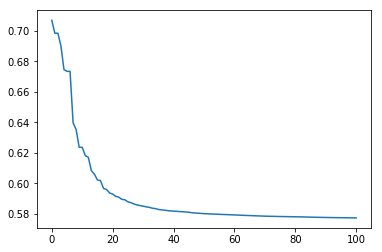

In [43]:
nnet = nn.NeuralNetwork(trainXdata.shape[1], [3,3,3,3], trainTdata.shape[1])
nnet.train(trainXdata, trainTdata, 100)
plt.plot(nnet.getErrorTrace())

Plots showed that error converages quickly for this data and is no longer decreasing after 100 iterations, so 100 iterations was chosen for training.  
Tests run with:

In [32]:
iterations = 100
repetitions = 10

After extensively testing many different neural network structures on the two data sets, we found that structures with higher node counts very quickly overfit the model to the testing data and were not adequate for predicting future data. As a result, neural networks were tested with structures with lower node counts, as well as, a structure with no hidden layers. The neural network with no hidden layers that was trained with the 2010-2017 data consistently outperformed the neural networks trained with the other structures and the other data set at predicting the outcomes of the 2017 NCAA Tournament games, with an average error of 14.74 points per game. The same neural network was also one of the best for generally predicting new data with an average error of 15.96 points per game. A neural network with no hidden layers is an adequate model because it will not overfit the data and is very good at predicting future outcomes, assuming the the data has linear properties. The fact that the neural network with no hidden layers preformed the best suggests that the data is linearly separable. Neural networks with no hidden layers also have the advantage of training faster than any of structure. As a result, the neural network with no hidden layers is the best for predicting the final overall score of future games.  

An error of 14.74 points per game seems to be relatively high, but we believe it is a fairly good estimate due to the high variance and unpredictability of individual games. Teams can play each other multiple times and end with different scores, resulting in sets of the same input data with different target data, increasing the variablility of the data.  

As we predicted, the data set with game data from 2010-2017 outperformed the data set with all the the game data we collected. We believe this is a result of games before 2010, especially games in the 90's, not being reflective of how college basketball is played today, due to rule changes and the increase of one and done players. This can also be attributed to the fact that the data set with game data from 2010-2017 has twice as many input variables per team because data collection has been much more complete is the recent years.

#### Training neural network with all games from the 2010-2016 seasons and the regular season of 2017 as training data and with all tournament games from the 2017 NCAA Tournament as testing data

0 done
[0, 15.899624842295699, 14.746068949636012, 4.641751050949097]


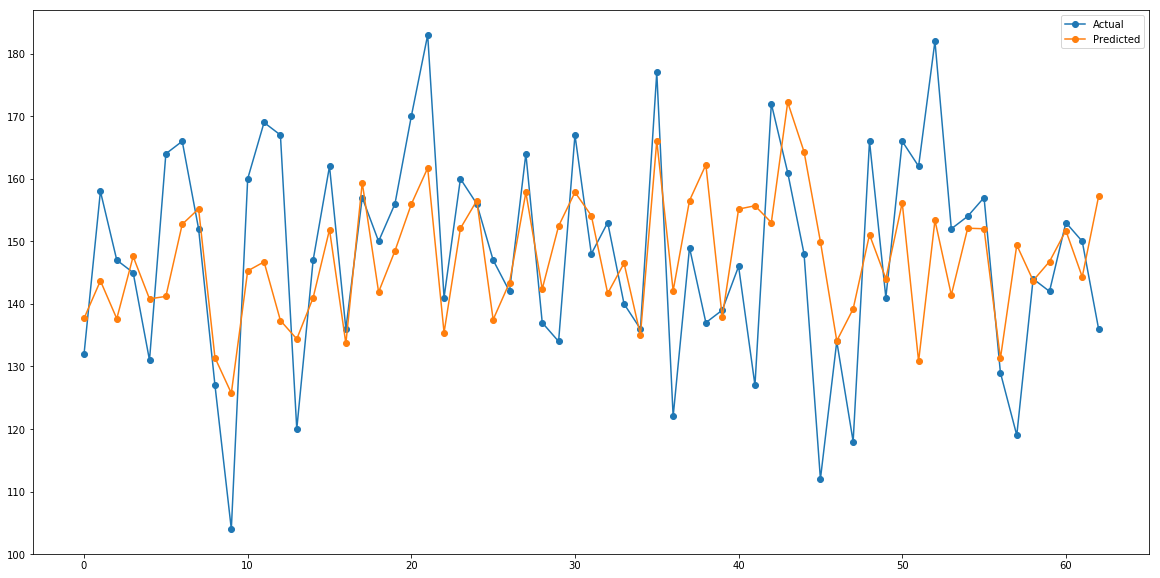

In [39]:
results = train.trainNNsWithTrainData(trainXdata, trainTdata, testXdata,testTdata, [0], repetitions, iterations)
summary = train.summarize(results)
best = train.bestNetwork(summary)
print(best)

nnet = nn.NeuralNetwork(trainXdata.shape[1], best[0], trainTdata.shape[1])
nnet.train(trainXdata, trainTdata, nIterations=iterations)
YtestData = nnet.use(testXdata)

plt.figure(figsize=(20,10))
plt.plot(testTdata[:,0],'o-',label="Actual")
plt.plot(YtestData[:,0],'o-',label="Predicted")
plt.legend()

#### Training neural network with 80% of games from the 2010-2017 seasons as training data and with the remaining 20% as testing data

0 done
[0, 15.890157779576432, 15.957346012932877, 3.5050148963928223]


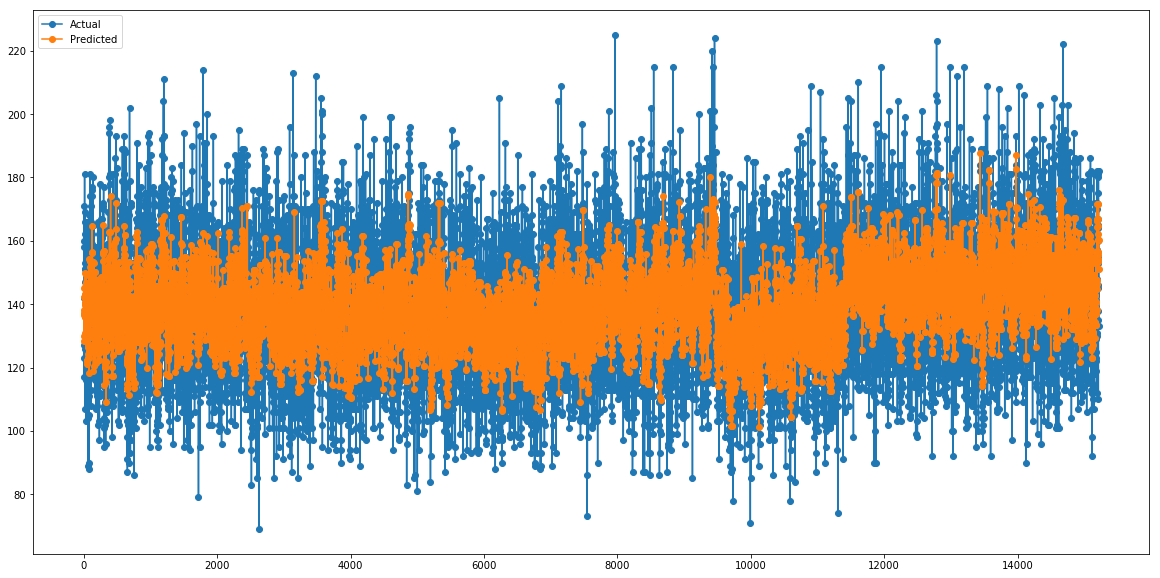

In [40]:
results = train.trainNNs(trainAllXdata, trainAllTdata, .8, [0], repetitions, iterations)
summary = train.summarize(results)
best = train.bestNetwork(summary)
print(best)

nnet = nn.NeuralNetwork(trainAllXdata.shape[1], best[0], trainAllTdata.shape[1])
nnet.train(trainAllXdata, trainAllTdata, nIterations=iterations)
YtestData = nnet.use(trainAllXdata)

plt.figure(figsize=(20,10))
plt.plot(trainAllTdata[:,0],'o-',label="Actual")
plt.plot(YtestData[:,0],'o-',label="Predicted")
plt.legend()

We then focused on using the neural network for classification. Meaning the network had only discrete outputs as opposed to continous ones. The previous outputs gave score values anywhere between 150 and 151 for example. In the case of this classification method their are only two outputs either a 1 representing the game was over the predicted score or a 0 meaning the game was under the predicted score. The code for this neural network is similar to that of the non classification neural network.

In [13]:
with open("classification_data.pkl","rb") as f:
    trainAllData = pickle.load(f)
trainAllTdata = trainAllData[:,-1]
trainAllTdata = np.row_stack(trainAllTdata)
trainAllXdata = trainAllData[:,0:-1]
trainAllTdata.shape, trainAllXdata.shape

((196, 1), (196, 16))

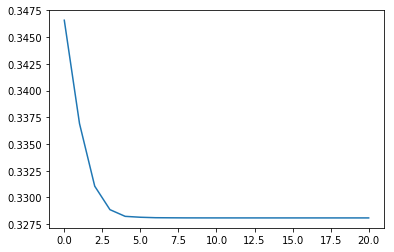

In [14]:
nnet = nn.NeuralNetworkClassifier(trainAllXdata.shape[1], [0], trainAllTdata.shape[1]+1)
nnet.train(trainAllXdata, trainAllTdata, 20)
plt.plot(nnet.getErrorTrace())

In [15]:
iterations = 10
repetitions = 20
nns = [0,2,5,[4,4],[5,5],[1,1,1,1],[3,3,3,3],[3,3,3,3,3]]

0 done
2 done
5 done
[4, 4] done
[5, 5] done
[1, 1, 1, 1] done
[3, 3, 3, 3] done
[3, 3, 3, 3, 3] done
Percent Error:  0.377551020408


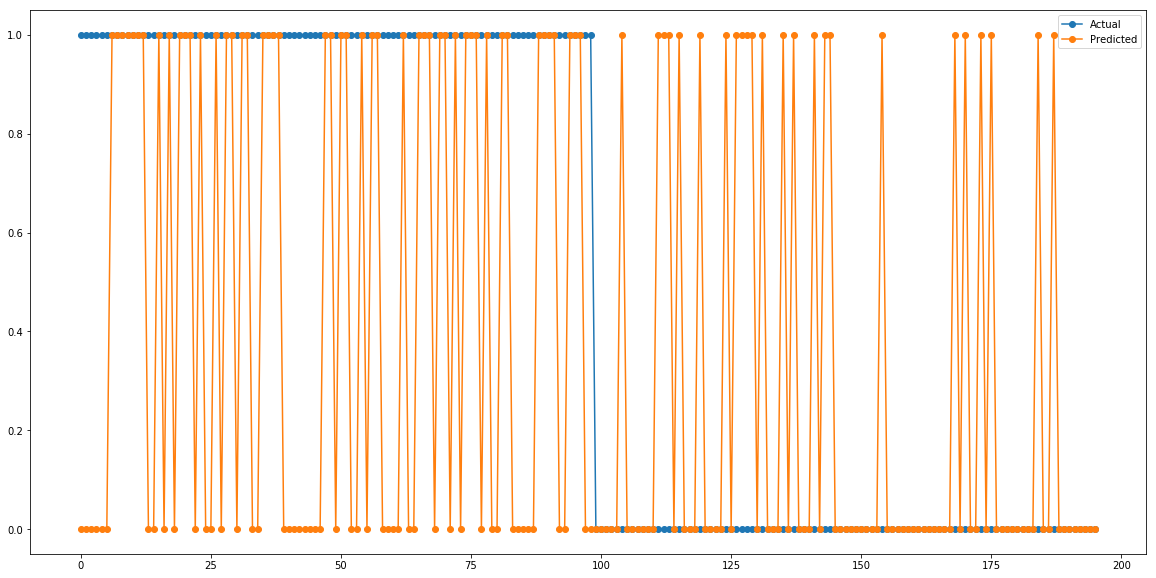

In [16]:
results = train.trainNNs(trainAllXdata, trainAllTdata, .5, nns, repetitions, iterations, True)
nnet = nn.NeuralNetworkClassifier(trainAllXdata.shape[1], best[0], trainAllTdata.shape[1]+1)
nnet.train(trainAllXdata, trainAllTdata, nIterations=iterations)
YtestData = nnet.use(trainAllXdata)
plt.figure(figsize=(20,10))
plt.plot(trainAllTdata[:,0],'o-',label="Actual")
plt.plot(YtestData[:,0],'o-',label="Predicted")
plt.legend()
print("Percent Error: ",(np.sum(np.abs(YtestData - trainAllTdata)))/trainAllTdata.shape[0])

The classification of this neural network produced the above graph that illustrates the difference between the expected value and the that the game resulted in and the value that was predicted based on the nerual network. After running this simulation many times and changing the partitioning fraction the average difference between the expected values and the actuall values was about 40% difference. This means that the nerual network was predicting the correct over under pick around 60% of the time. Based on betting standards this is a very good result. 

#### Work Load

Andrew and Blake both worked on the web scrapping as well as the machine learning aspects of this problem. The break down of the work is depicted below:
##### Andrew:
* Web scraping for all the tournament games scores
* Web scraping for all the team stats from each year
* Web scraping for some of the game data
* Formatting of all this data
* Creation of the Neural Network
* Writting of the report

##### Blake:
* Web scraping for the rest of the team game data
* Web scraping of the over under data
* Formatting of all this data
* Creation of the Neural Network Classifier
* Writting of the report


Both Andrew and Blake discuessed what they did based on the above bullet points in the report.

## Conclusions

This assignment taught us how to logically and systematically traverse the web to find data that would be useful for predicting NCAA basketball game scores. This topic had plenty of data due to the fact that NCAA basketball is a popular pass time in the United State and also because statistical analysis of NCAA basketball is very popular. This data took some time to find and to determine how to obtain it from websites using python. We also learned how to test different sets of data in order to reach different solutions. Specifically we learned about neural networks that predict continuous outputs based on output data that can be of any value. We also learned about neural networks that classify data into dicrete categories based on dicrete outputs from the neural network. The neural network we implemented used logistic regression that was opomized with gradient descent. We learned the effect of using different statistics to predict NCAA basketball game scores and how these different statistics trained the nueral network differentl. Overall, we got experience working with data mining, neural networks optimization, and statistical analysis of basketball games. 

### References

[1] M. F. Møller, A scaled conjugate gradient algorithm for fast supervised learning, vol. 6. Aarhus: Aarhus University. Department of Computer Science, 1990. 
   
[2] Charles Anderson   
   
[3] S. J. Russell and P. Norvig, [Artificial Intelligence: A Modern Approach](http://aima.cs.berkeley.edu/). Stuart Russell ; Peter Norvig. New Jersey: Prentice Hall, 2014.   



In [17]:
import io
from nbformat import current
import glob
nbfile = glob.glob('project_writeup.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file project_writeup.ipynb is 2985
